In [ ]:
##!/usr/bin/env python
"""plot_cmip_skill.py

This script compares the heatwave diagnostics of CMIP6 to Berkeley Earth

Using the Excess Heat Factor 
Baseline Period: 1950-2014, 90th Percentile Threshold

Author: Annette L Hirsch @ CLEX, UNSW. Sydney (Australia)
email: a.hirsch@unsw.edu.au
Created: Wed Nov 11 10:54:39 AEDT 2020

"""

### Load Python Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
#from __future__ import division
import numpy as np
import netCDF4 as nc
import sys
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import cartopy.crs as ccrs
import xesmf as xe
from scipy import stats
from scipy import signal
import math
import regionmask

### Berkeley Earth

This data has nlat = 150, nlon = 360 so it is 1deg data

In [2]:
berkdir = '/g/data/w97/azh561/cmip_heatwave/BerkleyEarth/tas/'

betrendmap = 'BerkleyEarth_tas_trend_1950_2014.nc'

# Read in the Berkeley Earth data - decode times necessary as HWF and HWD in units of days
berk = xr.open_dataset('%s%s' %(berkdir,betrendmap))
lat1d = berk['latitude'].values # Excludes Antarctica
lon1d = berk['longitude'].values

# Define the common grid for the models to regrid too!
ds_out = xr.Dataset({'lat': (['lat'], berk['latitude'].values),
         'lon': (['lon'], berk['longitude'].values),
        })


nlat,nlon = len(lat1d),len(lon1d)

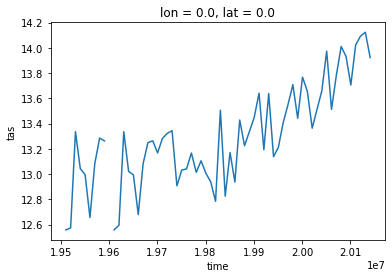

In [3]:
betas = 'Berkley_Earth_tas_1940_2014_yearly_mean_global_avg.nc'

# Read in the Berkeley Earth data - decode times necessary as HWF and HWD in units of days
berkts = xr.open_dataset('%s%s' %(berkdir,betas),decode_times=False)

berkts['tas']= xr.where(berkts['tas']<11., np.nan, berkts['tas'])
berkts['tas'].isel(time=slice(10,75)).plot()



### CMIP6 data

Note that in this instance we start with the first ensemble member 'r1i1p1f1' for all models

They are all on different resolutions! So will require regridding to plot and evaluate:

    - finest resolution: nlat = 256, nlon = 512 -> 0.7 deg x 0.7 deg
    - coarsest resolution: nlat = 96, nlon = 144 -> 1.875 deg x 2.5 deg

In [4]:
cmip6dir = '/g/data/w35/nr8596/CMIP6/ce_analys_input/CMIP/historical/'

# Define the models

models6 = ['ACCESS-CM2','AWI-CM-1-1-MR','AWI-ESM-1-1-LR','BCC-CSM2-MR','BCC-ESM1','CanESM5','CMCC-CM2-SR5',
'EC-Earth3-AerChem','EC-Earth3','EC-Earth3-Veg','EC-Earth3-Veg-LR','FGOALS-f3-L','FGOALS-g3',#'GFDL-CM4',
'GFDL-ESM4',#'GISS-E2-1-G',
'INM-CM4-8','INM-CM5-0','IPSL-CM6A-LR','KACE-1-0-G','KIOST-ESM','MIROC6',
'MPI-ESM-1-2-HAM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','NorCPM1','NorESM2-LM','NorESM2-MM','TaiESM1']
nmod6 = len(models6)

# Define the filename convention:
str6a = '/orig/an_tas_trend/trend_an_tavg_'
str6b = '_historical_deg_C_1950-2014_r1i1p1f1.nc'


In [5]:
# Now loop through the models and regrid
moddata6 = np.empty((nmod6,nlat,nlon),dtype=np.float64)
for mind in range(nmod6):
    
    dm = xr.open_dataset('%s%s%s%s%s' %(cmip6dir,models6[mind],str6a,models6[mind],str6b),decode_times=False)
    dm = dm.rename({'lon': 'lat1d'})
    dm = dm.rename({'lat': 'lon1d'})
    dm = dm.rename({'lat1d': 'lat'})
    dm = dm.rename({'lon1d': 'lon'})
    
    if np.nanmax(dm['lon']) > 200.:
        lon_name = 'lon'
        dm['_longitude_adjusted'] = xr.where(dm[lon_name] > 180,dm[lon_name] - 360,dm[lon_name])
        # reassign the new coords to as the main lon coords and sort DataArray using new coordinate values
        dm = (
            dm
            .swap_dims({lon_name: '_longitude_adjusted'})
            .sel(**{'_longitude_adjusted': sorted(dm._longitude_adjusted)})
            .drop(lon_name))
        dm = dm.rename({'_longitude_adjusted': lon_name})

    datavalue = dm['trend']
    regridder = xe.Regridder(dm, ds_out, 'bilinear')
    moddata6[mind,:,:] = regridder(datavalue)
    
#    dm['trend'].plot()
    
    del dm, datavalue,regridder


In [5]:
# Get the time series

# Now loop through the models and regrid
modts6 = np.empty((nmod6,65),dtype=np.float64)
for mind in range(nmod6):
    
    dm = xr.open_dataset('%s%s%s%s%s' %(cmip6dir,models6[mind],'/orig/an_tas_trend/an_wghtd_gm_tas_',models6[mind],'_historical_r1i1p1f1_19500101_20141231.nc'),decode_times=False)    
    modts6[mind,:] = dm['an_gm_tas'].isel(lat=0,lon=0)
    year = dm['year']
    del dm

### CMIP5 data

Note that in this instance we start with the first ensemble member 'r1i1p1' for all models


In [6]:
cmip5dir = '/g/data/w35/nr8596/CMIP5/historical/'

# Define the models
models5 = ['ACCESS1-0',#'ACCESS1.3',
           'bcc-csm1-1','bcc-csm1-1-m','BNU-ESM',
          'CanESM2','CCSM4','CESM1-BGC','CESM1-CAM5','CMCC-CESM',
'CMCC-CM','CMCC-CMS',#'CNRM-CM5',
           'CSIRO-Mk3-6-0',#'FGOALS_g2',
           'GFDL-CM3',
'GFDL-ESM2G','GFDL-ESM2M',#'HadGEM2-AO','HadGEM2-CC','HadGEM2-ES','inmcm4',
'IPSL-CM5A-LR','IPSL-CM5A-MR',#'IPSL-CM5B-LR','MIROC5',
           'MIROC-ESM-CHEM',
'MIROC-ESM','MPI-ESM-LR',#'MPI-ESM-MR','MRI-CGCM3','MRI-ESM1',
           'NorESM1-M']

nmod5 = len(models5)

# Define the filename convention:
str5a = '/orig/an_tas_trend/trend_an_tavg_'
str5b = 'r1i1p1_deg_C_1950_2014_historical_rcp4.5_regrid_setgrid.nc'

In [8]:
# Now loop through the models and regrid
moddata5 = np.empty((nmod5,nlat,nlon),dtype=np.float64)
for mind in range(nmod5):
    
    dm = xr.open_dataset('%s%s%s%s%s' %(cmip5dir,models5[mind],str5a,models5[mind],str5b),decode_times=False)    
    dm = dm.rename({'lon': 'lat1d'})
    dm = dm.rename({'lat': 'lon1d'})
    dm = dm.rename({'lat1d': 'lat'})
    dm = dm.rename({'lon1d': 'lon'})
    
    if np.nanmax(dm['lon']) > 200.:
        lon_name = 'lon'
        dm['_longitude_adjusted'] = xr.where(dm[lon_name] > 180,dm[lon_name] - 360,dm[lon_name])
        # reassign the new coords to as the main lon coords and sort DataArray using new coordinate values
        dm = (
            dm
            .swap_dims({lon_name: '_longitude_adjusted'})
            .sel(**{'_longitude_adjusted': sorted(dm._longitude_adjusted)})
            .drop(lon_name))
        dm = dm.rename({'_longitude_adjusted': lon_name})

    datavalue = dm['trend'] # to convert to degC/decade
    regridder = xe.Regridder(dm, ds_out, 'bilinear')
    moddata5[mind,:,:] = regridder(datavalue)
    del dm, datavalue,regridder


In [11]:
# Get the time series

# Define the models
models5 = ['ACCESS1-0','ACCESS1-3','bcc-csm1-1','bcc-csm1-1-m','BNU-ESM',
          'CanESM2','CCSM4','CESM1-BGC','CESM1-CAM5','CMCC-CESM',
            'CMCC-CM','CMCC-CMS','CNRM-CM5','CSIRO-Mk3-6-0','FGOALS-g2',
           'GFDL-CM3','GFDL-ESM2G','GFDL-ESM2M',#'HadGEM2-AO','HadGEM2-CC','HadGEM2-ES',
           'inmcm4','IPSL-CM5A-LR','IPSL-CM5A-MR','IPSL-CM5B-LR','MIROC5',
           'MIROC-ESM-CHEM','MIROC-ESM','MPI-ESM-LR','MPI-ESM-MR','MRI-CGCM3','MRI-ESM1',
           'NorESM1-M']

nmod5 = len(models5)

# Now loop through the models and regrid
modts5 = np.empty((nmod5,65),dtype=np.float64)
for mind in range(nmod5):
    
    dm = xr.open_dataset('%s%s%s%s%s' %(cmip5dir,models5[mind],'/orig/an_tas_trend/an_wghtd_gm_tavg_',models5[mind],'_r1i1p1_deg_C_1950_2014_historical_rcp4.5_regrid_setgrid.nc'),decode_times=False)    
    modts5[mind,:] = dm['an_gm_tas']
    year = dm['year']
    del dm

Mask the data

In [9]:
# Define the land-sea mask (region = 0, elsewhere is nan)
ar6_land = regionmask.defined_regions.ar6.land
land_110 = regionmask.defined_regions.natural_earth.land_110
land_mask = land_110.mask(ds_out)
mask2d = ar6_land.mask(ds_out) * land_mask.squeeze(drop=True)
maskreg = ar6_land.mask(ds_out)
maskland = maskreg * land_mask.squeeze(drop=True)

# Mask the data
berkma = np.ma.masked_array(berk['trends'],maskland!=0).filled(np.nan)

trend6ma = np.ma.masked_array(np.nanmean(moddata6*10.,axis=0),maskland!=0).filled(np.nan)
trend5ma = np.ma.masked_array(np.nanmean(moddata5*10.,axis=0),maskland!=0).filled(np.nan)

std6ma = np.ma.masked_array(np.nanstd(moddata6*10.,axis=0),maskland!=0).filled(np.nan)
std5ma = np.ma.masked_array(np.nanstd(moddata5*10.,axis=0),maskland!=0).filled(np.nan)

#### For Contour Plots

In [10]:
def plot_ensemble_contour(lat1d,lon1d,odata,data6,data6std,data5,data5std,mn,mx,figurename):

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.colors import BoundaryNorm
    from matplotlib.ticker import MaxNLocator
    from matplotlib import colors
    from matplotlib import cm
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    import cartopy.crs as ccrs
    from string import ascii_lowercase
    
    # Figure formatting
    plt.rcParams['savefig.dpi']=300
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    
    # Set up projection
    plotcrs = ccrs.PlateCarree(central_longitude=0)
    lon2d, lat2d = np.meshgrid(lon1d, lat1d)
    
    nrow = 3
    ncol = 2
    
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol, figsize=((5.5*ncol),2*nrow), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

    # Define the colormaps
    cmap = plt.get_cmap('YlOrRd')
    cmap.set_bad('w')               
        
    # Berkeley Earth
    cm = ax[0,0].contourf(lon2d,lat2d,odata,vmin=mn,vmax=mx,cmap=cmap,levels=MaxNLocator(nbins=10).tick_values(mn,mx), 
                               norm=BoundaryNorm(MaxNLocator(nbins=10).tick_values(mn,mx), ncolors=cmap.N, clip=True), 
                           extend='both',transform=ccrs.PlateCarree())
    ax[0,0].coastlines()
    ax[0,0].text(0.016,0.035,'(%s)' %(ascii_lowercase[0]),horizontalalignment='left',verticalalignment='bottom',
                      transform = ax[0,0].transAxes,fontweight='bold', fontsize=14)
    plt.colorbar(cm, ax=ax[0,0])
    ax[0,0].set_title('Berkeley Earth', fontweight='bold', fontsize=14)
        
    # CMIP6 Ensemble Mean
    cm = ax[1,0].contourf(lon2d,lat2d,data6,vmin=mn,vmax=mx,cmap=cmap,levels=MaxNLocator(nbins=10).tick_values(mn,mx), 
                               norm=BoundaryNorm(MaxNLocator(nbins=10).tick_values(mn,mx), ncolors=cmap.N, clip=True), 
                           extend='both',transform=ccrs.PlateCarree())
    ax[1,0].coastlines()
    ax[1,0].text(0.016,0.035,'(%s)' %(ascii_lowercase[1]),horizontalalignment='left',verticalalignment='bottom',
                      transform = ax[1,0].transAxes,fontweight='bold', fontsize=14)
    plt.colorbar(cm, ax=ax[1,0])
    ax[1,0].set_title('CMIP6 Ensemble: Mean', fontweight='bold', fontsize=14)

    # CMIP5 Ensemble Mean
    cm = ax[2,0].contourf(lon2d,lat2d,data5,vmin=mn,vmax=mx,cmap=cmap,levels=MaxNLocator(nbins=10).tick_values(mn,mx), 
                               norm=BoundaryNorm(MaxNLocator(nbins=10).tick_values(mn,mx), ncolors=cmap.N, clip=True), 
                           extend='both',transform=ccrs.PlateCarree())
    ax[2,0].coastlines()
    ax[2,0].text(0.016,0.035,'(%s)' %(ascii_lowercase[3]),horizontalalignment='left',verticalalignment='bottom',
                      transform = ax[2,0].transAxes,fontweight='bold', fontsize=14)
    plt.colorbar(cm, ax=ax[2,0])
    ax[2,0].set_title('CMIP5 Ensemble: Mean', fontweight='bold', fontsize=14)

    
    mx = 0.25
    
    
    # CMIP6 Ensemble Std Dev
    cm = ax[1,1].contourf(lon2d,lat2d,data6std,vmin=mn,vmax=mx,cmap=cmap,levels=MaxNLocator(nbins=10).tick_values(mn,mx), 
                               norm=BoundaryNorm(MaxNLocator(nbins=10).tick_values(mn,mx), ncolors=cmap.N, clip=True), 
                           extend='both',transform=ccrs.PlateCarree())
    ax[1,1].coastlines()
    ax[1,1].text(0.016,0.035,'(%s)' %(ascii_lowercase[2]),horizontalalignment='left',verticalalignment='bottom',
                      transform = ax[1,1].transAxes,fontweight='bold', fontsize=14)
    plt.colorbar(cm, ax=ax[1,1])
    ax[1,1].set_title('CMIP6 Ensemble: Std. Dev.', fontweight='bold', fontsize=14)


    # CMIP5 Ensemble Std Dev
    cm = ax[2,1].contourf(lon2d,lat2d,data5std,vmin=mn,vmax=mx,cmap=cmap,levels=MaxNLocator(nbins=10).tick_values(mn,mx), 
                               norm=BoundaryNorm(MaxNLocator(nbins=10).tick_values(mn,mx), ncolors=cmap.N, clip=True), 
                           extend='both',transform=ccrs.PlateCarree())
    ax[2,1].coastlines()
    ax[2,1].text(0.016,0.035,'(%s)' %(ascii_lowercase[4]),horizontalalignment='left',verticalalignment='bottom',
                      transform = ax[2,1].transAxes,fontweight='bold', fontsize=14)
    plt.colorbar(cm, ax=ax[2,1])
    ax[2,1].set_title('CMIP5 Ensemble: Std. Dev.', fontweight='bold', fontsize=14)

    fig.delaxes(ax[0,1])
    
    fig.subplots_adjust(wspace=0.0001, hspace=0.25)

    plt.savefig(figurename, bbox_inches='tight')
#    plt.close(fig)


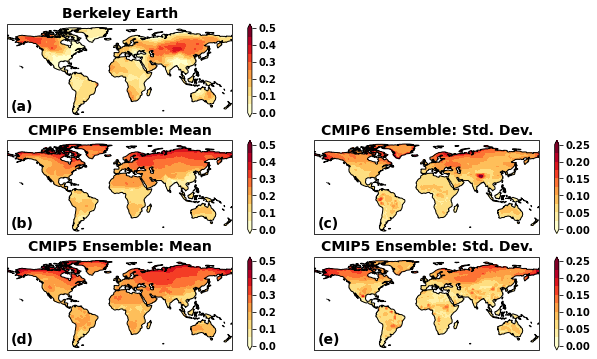

In [11]:

plot_ensemble_contour(lat1d,lon1d,berkma,trend6ma,std6ma,trend5ma,std5ma,0.,0.5,'contour_warming_trend_CMIP6andCMIP5.png')


Create the time series

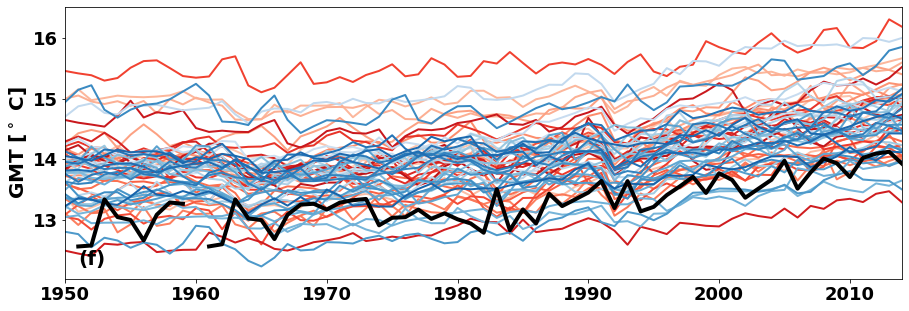

In [13]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import string
from string import ascii_lowercase

# Figure formatting
plt.rcParams['savefig.dpi']=300
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.size"] = 18


# Create figure object and subplots
fig, ax = plt.subplots(1, 1, figsize=(15.0,5.0), squeeze=False)


# CMIP6
evenly_spaced_interval = np.linspace(0.2, 0.8, nmod6)
myreds = [plt.cm.Reds(x) for x in evenly_spaced_interval]
for mind in range(nmod6):
    ax[0,0].plot(year,modts6[mind,:],linestyle='-',linewidth=2,color=myreds[mind])

# CMIP5
evenly_spaced_interval = np.linspace(0.2, 0.8, nmod5)
myblues = [plt.cm.Blues(x) for x in evenly_spaced_interval]
for mind in range(nmod5):
    ax[0,0].plot(year,modts5[mind,:],linestyle='-',linewidth=2,color=myblues[mind])

# Observations
ax[0,0].plot(year,berkts['tas'].isel(time=slice(10,75),lat=0,lon=0),linestyle='-',linewidth=4,color='black',label='BE')

# Fix Labelling
ax[0,0].set_ylabel('GMT [$^\circ$ C]', fontweight = 'bold',fontsize=20)
ax[0,0].set_xlim(1950,2014)
ax[0,0].text(0.016,0.035,'(%s)' %(ascii_lowercase[5]),horizontalalignment='left',verticalalignment='bottom',
                      transform = ax[0,0].transAxes,fontweight='bold', fontsize=20)

fig.savefig('GMT_timeseries.png',bbox_inches='tight')#bbox_extra_artists=(legend,), bbox_inches='tight')
#    plt.close(fig)
